# Custom Models, Training & Data Loaders

In [1]:
import scQUEST as scq
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchmetrics
import pytorch_lightning as pl

import scanpy as sc
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore', ".* does not have many workers.*")

## Custom Models
The models used by the `Classifier` or the `Abnormality` class are defined in [PyTorch](https://pytorch.org/) and [PyTorch Lightning](https://www.pytorchlightning.ai/). When using custom models we can either:

    1. Define a model with PyTorch
    2. Derive a PyTorch Lightning module from the PyTorch model
    
Using the pytorch lightning module enables the advanced user to further customize the training of the model itself.

### Pytorch Model
To learn more about how to define PyTorch models refer to its exhaustive [documentation](https://pytorch.org/tutorials/).

In the _scQUEST Tutorial_ we used by default 36 input features, but this can be easily tuned to fit different needs. In the following snippet we define a new model with more features than the default model.

In [2]:
class MyTorchModel(nn.Module):

    def __init__(self, n_in=100):
        super().__init__()
        self.encoder = nn.Sequential(
                                   nn.Linear(n_in, 32), nn.ReLU(),
                                   nn.Linear(32, 16), nn.ReLU(),
                                   nn.Linear(16, 8), nn.ReLU(),
                                   nn.Linear(8, 4))
        
        self.decoder = nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                                   nn.Linear(8, 16), nn.ReLU(),
                                   nn.Linear(16, 32), nn.ReLU(),
                                   nn.Linear(32, n_in), nn.Sigmoid())

    def forward(self, x):
        return self.decoder(self.encoder(x))

use the autoencoder on some random data:

In [3]:
X = torch.rand(20,100)
model = MyTorchModel()
model(X)[:10, :5]

tensor([[0.5029, 0.5200, 0.5489, 0.4391, 0.4746],
        [0.5030, 0.5200, 0.5488, 0.4391, 0.4745],
        [0.5029, 0.5199, 0.5488, 0.4391, 0.4745],
        [0.5029, 0.5199, 0.5488, 0.4391, 0.4746],
        [0.5030, 0.5200, 0.5488, 0.4390, 0.4746],
        [0.5029, 0.5199, 0.5488, 0.4392, 0.4746],
        [0.5029, 0.5200, 0.5488, 0.4391, 0.4746],
        [0.5029, 0.5200, 0.5489, 0.4390, 0.4747],
        [0.5030, 0.5200, 0.5488, 0.4391, 0.4745],
        [0.5029, 0.5200, 0.5488, 0.4391, 0.4746]], grad_fn=<SliceBackward0>)

#### Apply Pytorch Model
That's already it. We can now pass the model as an argument:

In [4]:
Abn = scq.Abnormality(model=model)

### PyTorch Lightning Module
In the next step we derive a lightning module from our model. The lightning module defines all the steps to train our autoencoder. Advanced users can further customize the model training.
Note how we define a new `forward` function and how it differs from the `forward` function we defined in `MyTorchModel`. The `forward` function of `MyTorchModel` will return the reconstructed input data, on the other hand, in `MyLightningModule` we return the reconstruction error!

In [5]:
class MyLightningModule(pl.LightningModule):
    def __init__(self,n_in=100):
        super().__init__()
        self.model = MyTorchModel(n_in=n_in)
        self.loss = nn.MSELoss()
        self.metric_mse = torchmetrics.MeanSquaredError()

    def forward(self, x):
        return x - self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)  # self(x) would call self.forward(x)
        loss = self.loss(y_hat, y)
        self.log('fit_loss', loss.detach())
        self.log('train_mse', self.metric_mse(y_hat, y))
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)  # self(x) would call self.forward(x)
        loss = self.loss(y_hat, y)
        self.log('val_loss', loss.detach())
        self.log('val_mse', self.metric_mse(y_hat, y))
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)  # self(x) would call self.forward(x)
        loss = self.loss(y_hat, y)
        self.log('test_loss', loss.detach())
        self.log('test_mse', self.metric_mse(y_hat, y))
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

Let us instantiate the module and inspect it.
- we can see that our encoder and decoder were recognised as part of the model and we see the complete model structure
- we can see the loss that will be used for training
- and the metric logged during training and testing (`metric_mse`)

In [6]:
module = MyLightningModule()
module

MyLightningModule(
  (model): MyTorchModel(
    (encoder): Sequential(
      (0): Linear(in_features=100, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=16, bias=True)
      (3): ReLU()
      (4): Linear(in_features=16, out_features=8, bias=True)
      (5): ReLU()
      (6): Linear(in_features=8, out_features=4, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=16, bias=True)
      (3): ReLU()
      (4): Linear(in_features=16, out_features=32, bias=True)
      (5): ReLU()
      (6): Linear(in_features=32, out_features=100, bias=True)
      (7): Sigmoid()
    )
  )
  (loss): MSELoss()
  (metric_mse): MeanSquaredError()
)

#### Apply Custom Module
And as before we pass the module as argument.

In [7]:
Abn = scq.Abnormality(model=module)

## Custom Dataset
Customization of the training can also happen on the data level. By default, `Classifier` and `Abnormality` will pack the data in the `AnnData` object into a `pytorch.Dataset` and then derive a `pytorch_lightning.Datamodule` from it. Advanced users can provide such a `pytorch_lightning.Datamodule` which will be used instead of the default. 

### Pytorch Dataset
To continue the autoencoder example, we will now create our own datamodule for the training. In a first step we create a `pytorch.Dataset` class

In [8]:
class MyDataset(Dataset):
    def __init__(self, X):
        super().__init__()
        self.data = torch.tensor(X).float()

    def __getitem__(self, item):
        return self.data[item], self.data[item]

    def __len__(self):
        return len(self.data)

In [9]:
ds = MyDataset(np.random.rand(10000, 100))
X,y = ds[0] # iterate over dataset

### Pytorch Lightning Datamodule
In a next step we derive a Datamodule from this dataset. A datamodule simply packages everything needed to train the models in one class. More information can be found [here](https://pytorch-lightning.readthedocs.io/en/stable/extensions/datamodules.html).

In the `setup` function one can define how the dataset is split into the different `train`, `val` and `test` sets.

In [10]:
class MyDataModule(pl.LightningDataModule):
    def __init__(self, dataset, test_size: float = 0.2, validation_size: float = 0.1, batch_size: int = 256):
        super().__init__()
        l = len(dataset)
        self.ds: Dataset = dataset

        self.test_size = int(test_size * l)
        self.train_size = l - self.test_size
        self.validation_size = int(self.train_size * validation_size)
        self.fit_size = self.train_size - self.validation_size

        self.batch_size = batch_size

    def setup(self, stage=None):
        self.fit, self.test = random_split(self.ds, [self.train_size, self.test_size])
        self.fit, self.validation = random_split(self.fit, [self.fit_size, self.validation_size])

    def train_dataloader(self):
        return DataLoader(self.fit, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.validation, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size)

### Using the datamodule

In [11]:
# convert to pytorch dataset to lightning datamodule
dm = MyDataModule(ds, batch_size=50)

Abn = scq.Abnormality(n_in=100)
Abn.fit(datamodule=dm, enable_progress_bar=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                    | Type             | Params
-------------------------------------------------------------
0 | model                   | DefaultAE        | 2.2 K 
1 | loss                    | MSELoss          | 0     
2 | metric_meansquarederror | MeanSquaredError | 0     
-------------------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_loss              0.08185754716396332
test_metric_meansquarederror    0.08185756951570511
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Putting everything together
Let us now use a dataset from the `scanpy` package to put all the shown concepts together.

In [12]:
ad = sc.datasets.pbmc68k_reduced()
var = ad.var.copy()

ad = sc.concat([ad.copy() for _ in range(10)])  # replicate examples to increase dataset size
ad.obs_names_make_unique()
ad.var = pd.concat([ad.var,var], axis=1)
ad

/usr/local/Caskroom/miniconda/base/envs/scquest/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 7000 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    obsm: 'X_pca', 'X_umap'

Since this is a simple toy examples we extract the highly variable genes and select the first `N` genes

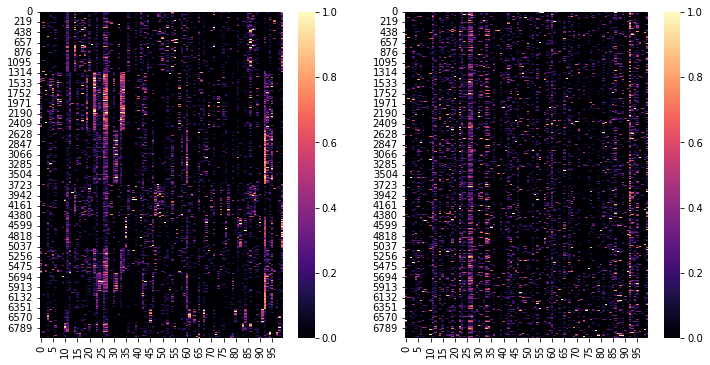

In [13]:
N = 100
ad = ad[:, ad.var.highly_variable]
ad = ad[:, :N]

ad.layers['X_norm'] = MinMaxScaler().fit_transform(ad.X)

fig, axs = plt.subplots(1,2, figsize=(12,6))
ax = sns.heatmap(ad.layers['X_norm'][np.argsort(ad.obs.louvain.values), :], ax=axs[0], cmap = 'magma')
ax = sns.heatmap(ad.layers['X_norm'], ax=axs[1], cmap = 'magma')

### Training Settings

In [14]:
# default
Abn = scq.Abnormality(n_in=N)
Abn.fit(ad, layer='X_norm', max_epochs=100, enable_progress_bar=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                    | Type             | Params
-------------------------------------------------------------
0 | model                   | DefaultAE        | 2.2 K 
1 | loss                    | MSELoss          | 0     
2 | metric_meansquarederror | MeanSquaredError | 0     
-------------------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)
/usr/local/Caskroom/miniconda/base/envs/scquest/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_loss              0.014781960286200047
test_metric_meansquarederror    0.014781961217522621
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [15]:
# custom model
model = MyTorchModel(n_in=N)
Abn = scq.Abnormality(model=model)
Abn.fit(ad, layer='X_norm', max_epochs=100, enable_progress_bar=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                    | Type             | Params
-------------------------------------------------------------
0 | model                   | MyTorchModel     | 8.0 K 
1 | loss                    | MSELoss          | 0     
2 | metric_meansquarederror | MeanSquaredError | 0     
-------------------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_loss               0.0106936264783144
test_metric_meansquarederror     0.0106936264783144
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [16]:
# custom module
module = MyLightningModule(n_in=N)
Abn = scq.Abnormality(model=module)
Abn.fit(ad, layer='X_norm', max_epochs=100, enable_progress_bar=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type             | Params
------------------------------------------------
0 | model      | MyTorchModel     | 8.0 K 
1 | loss       | MSELoss          | 0     
2 | metric_mse | MeanSquaredError | 0     
------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.01118183322250843
        test_mse            0.01118183322250843
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [17]:
# custom datamodule, default model
ds = MyDataset(ad.layers['X_norm'])
dm = MyDataModule(ds)

Abn = scq.Abnormality(n_in=N)
Abn.fit(datamodule=dm, max_epochs=100, enable_progress_bar=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                    | Type             | Params
-------------------------------------------------------------
0 | model                   | DefaultAE        | 2.2 K 
1 | loss                    | MSELoss          | 0     
2 | metric_meansquarederror | MeanSquaredError | 0     
-------------------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)
/usr/local/Caskroom/miniconda/base/envs/scquest/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_loss              0.014520150609314442
test_metric_meansquarederror    0.014520152471959591
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [18]:
# custom datamodule, custom model/module
dm = MyDataModule(ds)
module = MyLightningModule(n_in=N)

Abn = scq.Abnormality(model=module)
Abn.fit(datamodule=dm, max_epochs=10, enable_progress_bar=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type             | Params
------------------------------------------------
0 | model      | MyTorchModel     | 8.0 K 
1 | loss       | MSELoss          | 0     
2 | metric_mse | MeanSquaredError | 0     
------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.01485545001924038
        test_mse            0.01485545001924038
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Predict
Compute the reconstruction and visualise the error.

In [19]:
Abn.predict(ad, layer='X_norm')
ad.layers.keys()

KeysView(Layers with keys: X_norm, abnormality)

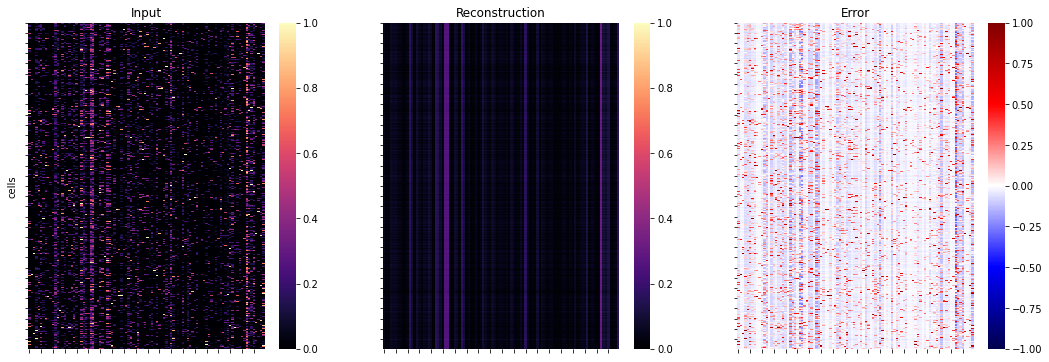

In [21]:
# estimate reconstruction error on the training data
y = ad.layers['X_norm']
yhat = Abn.model.model(torch.tensor(y)).detach().numpy()  # access base torch model
err = ad.layers['abnormality']

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax, dat, title in zip(axs.flat, [y, yhat, err], ['Input', 'Reconstruction', 'Error']):
    ax: plt.Axes
    cmap = 'seismic' if title == 'Error' else 'magma'
    vmin = -1 if title == 'Error' else 0
    _ = sns.heatmap(dat, ax=ax, cmap = cmap, vmin=vmin, vmax=1)
    ax.set_title(title)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
_ = axs[0].set_ylabel('cells')